<a href="https://colab.research.google.com/github/ArseniyKoz/uni.neuralnetworks/blob/main/nn_mnist_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np

In [ ]:
batch_size = 100
lr = 0.001

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

testset = datasets.MNIST("MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm") != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.conv1 = nn.Conv2d(1, 128, kernel_size=4, stride=2, padding=1, bias=False)
      self.lrelu = nn.LeakyReLU(0.1, inplace=True)

      self.conv2 = nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(64)

      self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1, bias=False)
      self.bn3 = nn.BatchNorm2d(32)

      self.conv4 = nn.Conv2d(32, 1, kernel_size=4, stride=1, bias=False)

      self.sigm = nn.Sigmoid()

    def forward(self, x):

      out = self.conv1(x)
      out = self.lrelu(out)

      out = self.conv2(out)
      out = self.bn2(out)
      out = self.lrelu(out)

      out = self.conv3(out)
      out = self.bn3(out)
      out = self.lrelu(out)

      out = self.conv4(out)
      #out = self.sigm(out)
      return out

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ct1 = nn.ConvTranspose2d(100, 32, kernel_size=4, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(True)

        self.ct2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.ct3 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        self.ct4 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False)

        self.tanh = nn.Tanh()


    def forward(self, x):

      out = self.ct1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.ct2(out)
      out = self.bn2(out)
      out = self.relu(out)

      out = self.ct3(out)
      out = self.bn3(out)
      out = self.relu(out)

      out = self.ct4(out)

      out = self.tanh(out)

      return out

In [ ]:
D = Discriminator()
G = Generator()

In [ ]:
G.apply(weight_init)
D.apply(weight_init)

Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (lrelu): LeakyReLU(negative_slope=0.1, inplace=True)
  (conv2): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (sigm): Sigmoid()
)

In [ ]:
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optim_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optim_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
D = D.cuda()
G = G.cuda()
criterion = criterion.cuda()

In [ ]:
EPOCHS = 50
FAKE_LABEL = 0.0
REAL_LABEL = 1.0
EVERY = 500

In [ ]:
import torchvision.utils as vutils
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=10, ncols=10, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu()
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)), cmap="gray")
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
samples = []
losses = []

fixed_noise = np.random.uniform(-1,1,size = (batch_size, 100, 1, 1))
fixed_noise = torch.from_numpy(fixed_noise).float().cuda()

D.train()
G.train()
for epoch in range(1, EPOCHS+1):
  loss_d = 0.0
  loss_g = 0.0

  for i, (images, labels) in enumerate(trainloader):

    images = images.cuda()
    #images = images*2 - 1

    fake_labels = torch.full((images.size(0), ), FAKE_LABEL).cuda()
    real_labels = torch.full((images.size(0), ), REAL_LABEL).cuda()

    #-------------------------#
    optim_D.zero_grad()

    d_real = D(images).view(-1)
    d_loss_real = criterion(d_real, real_labels)
    #d_loss_real.backward()

    noise = np.random.uniform(-1,1,size = (batch_size, 100, 1, 1))
    noise = torch.from_numpy(noise).float().cuda()
    fake_images = G(noise)

    d_fake = D(fake_images.detach()).view(-1)
    d_loss_fake = criterion(d_fake, fake_labels)
    #d_loss_fake.backward()

    d_loss = d_loss_real - d_loss_fake
    d_loss.backward()
    optim_D.step()
    #-------------------------#
    optim_G.zero_grad()

    noise = np.random.uniform(-1,1,size = (batch_size, 100, 1, 1))
    noise = torch.from_numpy(noise).float().cuda()
    fake_images = G(noise)

    d_fake = D(fake_images).view(-1)
    g_loss = criterion(d_fake, real_labels)
    g_loss.backward()

    optim_G.step()
    #-------------------------#

    if i % EVERY == 0:
      print(f"Epoch [{epoch}/{EPOCHS}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")


  losses.append((d_loss.item(), g_loss.item()))


  G.eval()
  samples_noise = G(fixed_noise)
  samples.append(samples_noise)
  G.train()

Epoch [1/50], Batch [0], LOSS_D: -0.06743133068084717, LOSS_G: 0.2187740057706833
Epoch [1/50], Batch [500], LOSS_D: -354.8143615722656, LOSS_G: 0.0
Epoch [2/50], Batch [0], LOSS_D: -483.7595520019531, LOSS_G: 0.0
Epoch [2/50], Batch [500], LOSS_D: -1415.83251953125, LOSS_G: 0.0
Epoch [3/50], Batch [0], LOSS_D: -1663.0697021484375, LOSS_G: 0.0
Epoch [3/50], Batch [500], LOSS_D: -3202.5634765625, LOSS_G: 0.0
Epoch [4/50], Batch [0], LOSS_D: -3566.563720703125, LOSS_G: 0.0
Epoch [4/50], Batch [500], LOSS_D: -5639.2451171875, LOSS_G: 0.0
Epoch [5/50], Batch [0], LOSS_D: -6100.08740234375, LOSS_G: 0.0


In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
view_samples(-1, samples)

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().cpu()
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)), cmap="gray")
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In [ ]:
fig = plt.figure(figsize=(10, 10))
torch.initial_seed()
rand_noise = np.random.uniform(-1,1,size = (batch_size, 100, 1, 1))
rand_noise = torch.from_numpy(rand_noise).float().cuda()
out = vutils.make_grid(G(rand_noise.cuda()).cpu().detach(), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap="gray")

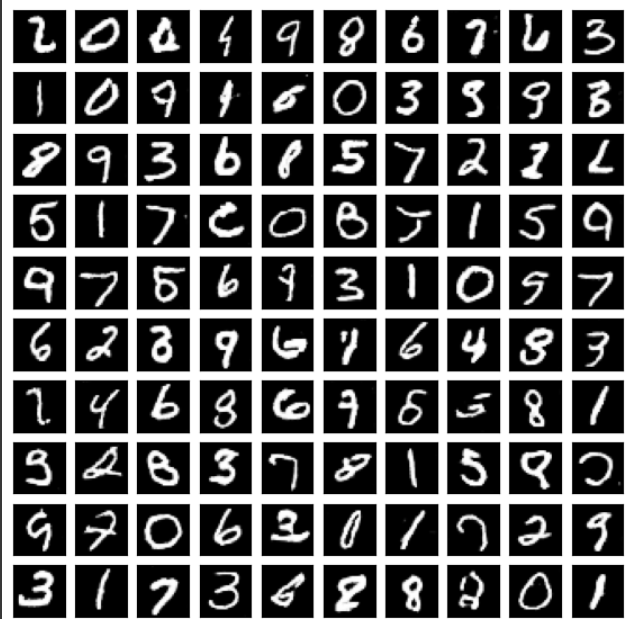